In [1]:
'''Loading libraries'''
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os 
import math

#path = ''
#os.chdir(path)
%matplotlib inline  

In [2]:
'''Loading Logistic Regresson Features by gene'''
#Pre-prossing on R
gsd = pd.read_table('data_gscore_features_bygene.csv', sep=';',index_col=False)
gsd.head()

,gene,ensembl_gene_id,gene_biotype,chromosome_name,start,end,g_score,mutsig,avg_expr,sirna
0,A1BG,ENSG00000121410,protein_coding,19,58345178,58353499,0.027891,-0.257187,5.419211,0.449420
1,A1CF,ENSG00000148584,protein_coding,10,50799409,50885675,0.009572,-0.012908,0.559459,-0.693753
2,A2M,ENSG00000175899,protein_coding,12,9067664,9116229,0.009709,-0.250799,13.373874,0.372179
3,A2ML1,ENSG00000166535,protein_coding,12,8822472,8887001,0.011142,-0.001836,3.841615,1.745096
4,A3GALT2,ENSG00000184389,protein_coding,1,33306766,33321098,0.022153,NaN,NaN,NaN


In [3]:
'''Normalization Features'''
#The bigger the value, higher the chance of being a driver gene
#print(features.head())
gsd['mutsig'] = gsd['mutsig']*(-1) 
gsd['sirna'] = gsd['sirna']*(-1)

gsd['mutsig'] = (gsd['mutsig']-gsd['mutsig'].mean())/(gsd['mutsig'].std())
gsd['avg_expr'] = (gsd['avg_expr']-gsd['avg_expr'].mean())/(gsd['avg_expr'].std())
gsd['sirna'] = (gsd['sirna']-gsd['sirna'].mean())/(gsd['sirna'].std())

In [4]:
'''Droping SiRNA and NA'''
print(gsd.shape)
gsd = gsd.dropna(axis=0,how='any')
print(gsd.shape)

(19279, 10)
(12957, 10)


In [5]:
'''Selecting top100 genes in each feature'''
#The top100 genes will be added into the final dataset, 
#even if their g-score is not very large

#mutsig
gsd = gsd.sort_values('mutsig', ascending=0)
top_genes_f = gsd['gene'].head(100)
#avg_expr
gsd = gsd.sort_values('avg_expr', ascending=0)
top_genes_f = top_genes_f.append(gsd['gene'].head(100))
#sirna
gsd = gsd.sort_values('sirna', ascending=0)
top_genes_f = top_genes_f.append(gsd['gene'].head(100))

#removing duplicated genes on the vector 
top_genes_f = top_genes_f.unique()
top_genes_f = set(top_genes_f)

'''Evaluation'''
intogen = ['ADCY1','AHNAK','AKAP9','APC','AQR','ARFGAP3','ARID1B','ATIC','ATM','ATRX','BCLAF1',
           'BCOR','BNC2','BPTF','BRAF','CASP1','CAT','CDC27','CDH1','CDKN1B','CEP290','CHD1L',
           'CHD3','CHD4','CHEK2','CNOT1','CNOT3','CNTNAP1','CTNNB1','CUL2','CUL3','EEF1B2','EGFR',
           'EIF2AK3','EIF4G1','EP300','ERCC2','FAT1','FGFR2','FIP1L1','FN1','FRG1','G3BP2','GNAS',
           'HGF','HNF1A','HRAS','HSP90AB1','HSPA8','IDH1','IRS2','KDM6A','KEAP1','MECOM','MED12',
           'MLL2','MYH10','NAP1L1','NKX3-1','NOTCH1','NOTCH2','NUP98','PCDH18','PIK3CB','PLXNA1',
           'PRPF8','PTEN','RPSAP58','SCAI','SETDB1','SMAD4','SMARCA1','SMARCB1','SPOP','SVEP1','TAOK2',
           'TBL1XR1','TBX3','THRAP3','TJP1','TJP2','TP53','TP53BP1','TRIO','WHSC1L1','WNT5A','ZFHX3','ZNF814']


census = ['ACSL3','AR','AXIN1','BRAF','CANT1','DDX5','ELK4','ERG','ETV1','ETV4','ETV5',
          'FOXA1','HERPUD1','HNRNPA2B1','KLF6','KLK2','NCOR2','NDRG1','PTEN','RAF1',
          'SALL4','SLC45A3','SPOP','TMPRSS2','ZFHX3']

evaluation = list(set(intogen) | set(census))

#forcing those genes to appear on the dataset
#top_genes_f = set.union(top_genes_f, evaluation)

'''This genes have high values from features, they should be at the data after
the filter, even if their g-score are not large'''
#Bool variable: 1 if gene is on top100 from features, 0 otherwise 
gsd['top_features'] = 0
gsd = gsd.reset_index(drop=True)

for i in np.arange(0,gsd.shape[0]):  
    if gsd.gene[i] in top_genes_f:
        gsd.loc[i,'top_features'] = 1

In [6]:
'''Defining driver genes model's seed'''
#top100 genes from g-score are used as driver genes seed
#top101-1500 genes from g-score or present in the top100 features are the passengers genes seed 
#The threhold 1500 was defined based on the paper (they mentioned 84 regions with about 14 genes each)
gsd = gsd.sort_values(by=['g_score'],axis=0,ascending=False)
gsd['top_gscore'] = 0
gsd['top_gscore'][101:1200] = 1

'''Creating data'''
#y: 1 if gene is driver, 0 otherwise 
gd = gsd[0:100]
gd['y']=1
gp = gsd.loc[((gsd.top_gscore==1) | (gsd.top_features==1))]
gp['y']=0

#new dataset deleting unimportant columns 
#some warnings, but everything is fine  
f = 4
data = pd.concat([gd,gp])
data['intercept']=1
data = data[['gene','g_score','intercept','mutsig','avg_expr','sirna','y']]
data.columns = ['gene','gscore','intercept','mutsig','avg_expr','sirna','y']

C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

In [7]:
'''Checking g-score distribution of driver and passengers genes'''
print('driver genes size - seed',gd['g_score'].shape)
print('passenger genes size - seed',gp['g_score'].shape)

driver genes size - seed (100,)
passenger genes size - seed (1369,)


In [8]:
'''Metropolis-Hastings algorithm'''
#Definitions 
#theta: set of unknown paramets
#using normal distribution instead of exponential distribution

#Unknown parameters - start values
#N(mu0,var0): driver genes
#N(mu1,var1): passenger genes
theta_start1 = [0,0,0,0] #w0,w1,w2,mu0, mu1, var0, var1
theta_start2 = [0.06,0.06,0.0004,0.0008] #w0,w1,w2,mu0, mu1, var0, var1
T = np.array(data['y'])

'''Likelihood 1: P(T|w,x)~logit()'''
def likelihood1_old(param,data,T,f):
    xw = data[['intercept','mutsig','avg_expr','sirna']].dot(param)
    l1 = 1/(1+np.exp(-xw))
    l0 = 1 - l1  
    l1[T==0] = l0[T==0]
    l1 = l1+0.000001
    return np.log(l1).sum()

'''Likelihood 2: P(Gscore|T,mean,sd)~Normal(mean,sd)'''
def likelihood2_old(param,T,data,f):
    media = T
    media=[param[0] if x==0 else param[1] for x in media]
    var = T
    var = [param[2] if x==0 else param[3] for x in var]
    l2 = scipy.stats.norm(media, np.sqrt(var)).pdf(data.gscore)
    #print('\n',data.gscore.mean(),data.gscore.var(),param[4:8],l2[0:3])
    return np.log(l2).sum()



In [9]:
'''Priori: w0,w1,w2,w3, mu0,mu1, var0,va1'''
def priori1(param,f):
    w = scipy.stats.norm(0,0.25).pdf(param[0:f])
    return np.log(w).sum()

'''Priori: w0,w1,w2,w3, mu0,mu1, var0,va1'''
def priori2(param,f):
    mu0 = scipy.stats.norm(0.04,np.sqrt(0.03)).pdf(param[0])
    mu1 = scipy.stats.norm(0.07,np.sqrt(0.01)).pdf(param[1])
    return (np.log(mu1)+np.log(mu0))

In [10]:
'''Posterior'''
def posterior2(param,T,data,f,l):
    #print(np.around(likelihood2_old(param,T,data,f),2),np.around(likelihood1_old(param,data,T,f),2),
    #      np.around(priori(param,f),2),np.around(param,4))
    #print(l,likelihood2_old(param,T,data,f),priori2(param,f),param)
    return (likelihood2_old(param,T,data,f)+priori2(param,f))

def posterior1(param,T,data,f,l):
    #print(l,likelihood1_old(param,data,T,f),priori1(param,f))
    return (likelihood1_old(param,data,T,f)+priori1(param,f))


#Vector with proposed values 
# Values are proposed from a Normal distribution
# mean is equal to current values and variance are hyperparameters 
#theta_proposed = np.random.normal(theta_current,[0.5,0.5,0.5,0.5,0.02,0.02,0.0004,0.0004])
'''ProposalValue'''
def proposalvalues1(param):
    part1 = np.random.normal(param[0:4],[0.075,0.075,0.075,0.075])
    return(part1)

def proposalvalues2(param):
    part1 = np.random.normal(param[0:2],[0.001,0.001])
    l = np.array(param[2:4])-0.00001
    l[l<=0.000001] = 0.000001
    h = np.array(param[2:4])+0.00001
    part2 = np.random.uniform(low = l, high = h)
    return(np.concatenate([part1,part2]))


In [11]:
def T_update_old(param1,param2,f):
    #print(param2,'\n')
    xw = data[['intercept','mutsig','avg_expr','sirna']].dot(param1)
    t11 = 1/(1+np.exp(-xw)) #array    
    t21 = scipy.stats.norm(param2[1], np.sqrt(param2[3])).pdf(data.gscore)

    t10 = 1-(1/(1+np.exp(-xw))) #array    
    t20 = scipy.stats.norm(param2[0], np.sqrt(param2[2])).pdf(data.gscore)
    
    t1 = t11*t21
    t0 = t10*t20
    
    prob_t1 = t1/(t1+t0)
    
    t_new = np.random.binomial(1,prob_t1,len(prob_t1))
    #print(t_new[0:10],'\n')
    return t_new


In [12]:
'''MCMC'''
def runMCMC_old(startvalue1,startvalue2,iterations,T,data,f):
    chain1 = np.zeros((iterations+1,len(startvalue1)))
    chain2 = np.zeros((iterations+1,len(startvalue2)))
    Tmatrix = np.zeros((iterations+1,len(T)))
    chain1[0]=proposalvalues1(startvalue1)
    chain2[0]=proposalvalues2(startvalue2)
    Tmatrix[0]=T
    for i in np.arange(iterations):
        #print('\n',i)

        proposal1 = proposalvalues1(chain1[i,])
        prob1 = np.exp(posterior1(proposal1,T,data,f,'p')-posterior1(chain1[i,],T,data,f,'c'))
        t1 = np.all(np.random.uniform(0,1,1) < prob1)   
                
        if t1: 
            chain1[i+1] = proposal1
            T = T_update_old(chain1[i+1],chain2[i],f) 
            Tmatrix[i+1] = T
        else: 
            chain1[i+1] = chain1[i]
            Tmatrix[i+1] = Tmatrix[i]
 
        proposal2 = proposalvalues2(chain2[i,])
        prob2 = np.exp(posterior2(proposal2,T,data,f,'p')-posterior2(chain2[i,],T,data,f,'c'))
        t2 = np.all(np.random.uniform(0,1,1) < prob2)

        if t2:
            chain2[i+1] = proposal2
        else: 
            chain2[i+1] = chain2[i]
            
#        if (t1) or (t2):
#            Tmatrix[i+1] = T
#        else:
#            Tmatrix[i+1] = Tmatrix[i]
            
    return chain1,chain2, T, Tmatrix        


In [13]:
f=4
chain1,chain2, Tnew, Tmatrix = runMCMC_old(theta_start1,theta_start2,8000,T,data,f)
np.savetxt('complete_chain1_T.csv',chain1,delimiter=';')
np.savetxt('complete_chain2_T.csv',chain2,delimiter=';')
np.savetxt('complete_matrix_T.csv',Tmatrix,delimiter=';')


acceptance rate (8001, 4) (2046, 4) 25.57180352455943
acceptance rate (8001, 4) (2487, 4) 31.083614548181476


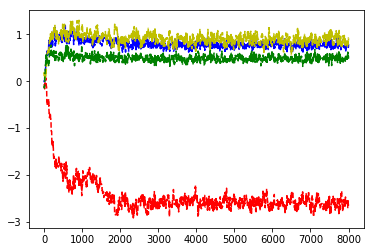

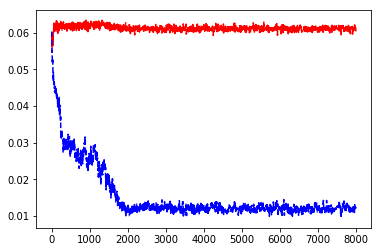

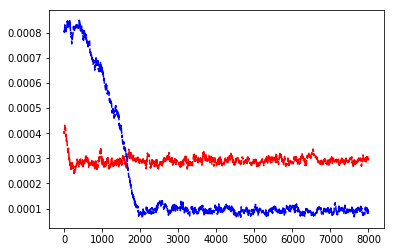

In [14]:
print('acceptance rate',chain1.shape, np.unique(chain1,axis=0).shape,np.unique(chain1,axis=0).shape[0]*100/chain1.shape[0])
print('acceptance rate',chain2.shape, np.unique(chain2,axis=0).shape,np.unique(chain2,axis=0).shape[0]*100/chain2.shape[0])

chain11 = pd.DataFrame(chain1, columns=['w0','w1','w2','w3'])
chain11['iteration'] = chain11.index
plt.plot(chain11.iteration,chain11.w0,'r--',
         chain11.iteration,chain11.w1,'b--',
         chain11.iteration,chain11.w2,'y--',
         chain11.iteration,chain11.w3,'g--')
plt.show()

chain22 = pd.DataFrame(chain2, columns=['mu0','mu1','var0','var1'])
chain22['iteration'] = chain22.index
plt.plot(chain22.iteration,chain22.mu0,'r--',
         chain22.iteration,chain22.mu1,'b--')
plt.show()
plt.plot(chain22.iteration,chain22.var0,'r--',
         chain22.iteration,chain22.var1,'b--')
plt.show()

In [24]:
print('last iteration T=1 elements',Tnew.sum())

Tmatrix = Tmatrix[int(Tmatrix.shape[0]*0.25):Tmatrix.shape[0]]
tprob = Tmatrix.sum(axis=0)/Tmatrix.shape[0]
#tfinal = np.random.binomial(1,tprob,len(tprob))
print(tprob.mean())
tfinal = tprob
tfinal = np.random.binomial(1,tprob,len(tprob))

gd = data[tfinal==1]
gp = data[tfinal==0]
print('driver genes size - final',gd['gscore'].shape[0])
print('passenger genes size - final',gp['gscore'].shape[0])




last iteration T=1 elements 237
0.160171058397
driver genes size - final 239
passenger genes size - final 1230


In [25]:
maximum = list(set(data.gene.tolist()).intersection(evaluation))

gene = gd.gene.tolist()
driver = list(set(gene).intersection(maximum))
print('Proportion of Driver from other lists (Recall): ', len(driver)*100/len(maximum),'%(',len(driver),'/',len(maximum),')')
print('Proportion of Driver Genes on Data: ',len(gene)*100/data.shape[0],'%(',len(gene),')')
print('Proportion of Driver Genes on other lists (Precision):',len(driver)*100/len(gene),'%')
#driver

Proportion of Driver from other lists (Recall):  63.63636363636363 %( 21 / 33 )
Proportion of Driver Genes on Data:  16.269571136827775 %( 239 )
Proportion of Driver Genes on other lists (Precision): 8.786610878661088 %


In [17]:
pd.options.display.max_rows = 4000
#gene

In [18]:
top100 = data
top100['prob'] = tprob
top100 = top100.sort_values("prob", axis=0, ascending=False)
genes100 = top100['gene'].head(100)
#list(genes100)

In [19]:
driver = list(set(genes100).intersection(maximum))
print('Proportion of Driver from other lists (Recall): ', len(driver)*100/len(maximum),'%(',len(driver),'/',len(maximum),')')
print('Proportion of Driver Genes on Data: ',len(genes100)*100/data.shape[0],'%(',len(genes100),')')
print('Proportion of Driver Genes on other lists (Precision):',len(driver)*100/len(genes100),'%')
#driver

Proportion of Driver from other lists (Recall):  39.39393939393939 %( 13 / 33 )
Proportion of Driver Genes on Data:  6.807351940095303 %( 100 )
Proportion of Driver Genes on other lists (Precision): 13.0 %
